In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import mat73
import time

# ------------------     MATLAB STUFF  ----------------------------------
def get_matlab_variables(mat_file_path):
    variables = mat73.loadmat(mat_file_path)
    #double gets converted to np array by default
    value_func_data = variables['Vx']
    lx_data = variables['lx'] 
    tau2 = variables['tau2']

    #Deriv is cell which gets converted into list of lists
    deriv_x_data = np.array(variables['Deriv'][0])
    deriv_x_data = deriv_x_data.squeeze()
    deriv_y_data = np.array(variables['Deriv'][1])
    deriv_y_data = deriv_y_data.squeeze()
    deriv_th_data = np.array(variables['Deriv'][2])
    deriv_th_data = deriv_th_data.squeeze()

    #g is struct whic gets converted into dic
    #vs is cell which give a list
    x_coord=np.array(variables['g']['vs'][0])
    y_coord=np.array(variables['g']['vs'][1])
    th_coord=np.array(variables['g']['vs'][2])
    x_coord = x_coord.squeeze()
    y_coord = y_coord.squeeze()
    th_coord = th_coord.squeeze()

    matlab_var_dict = dict( value_func_data=value_func_data,
                            lx_data=lx_data,
                            deriv_x_data=deriv_x_data,
                            deriv_y_data=deriv_y_data,
                            deriv_th_data=deriv_th_data,
                            x_coord=x_coord,
                            y_coord=y_coord,
                            th_coord=th_coord,
                            tau2=tau2
                           )
    return matlab_var_dict

def get_value_function(matlab_var_dict):
   val_func_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord']), matlab_var_dict['value_func_data'] ,  bounds_error=False, fill_value=None)
   return val_func_eval

def get_lx_function(matlab_var_dict):
   lx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord']), matlab_var_dict['lx_data'] ,  bounds_error=False, fill_value=None)
   return lx_eval

def get_deriv_x_function(matlab_var_dict):
   deriv_x_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_x_data'] ,  bounds_error=False, fill_value=None)
   return deriv_x_eval

def get_deriv_y_function(matlab_var_dict):
   deriv_y_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_y_data'] ,  bounds_error=False, fill_value=None)
   return deriv_y_eval

def get_deriv_th_function(matlab_var_dict):
   deriv_th_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_th_data'] ,  bounds_error=False, fill_value=None)
   return deriv_th_eval

def get_opt_control( deriv_x_fun, deriv_y_fun, deriv_th_fun, state, vMax, vMin, angleMax, u_mode = 'max'):
    # if strcmp(uMode, 'max')
    # uOpt{2} = (deriv{3}>=0)*obj.angleMax + (deriv{3}<0)*(-obj.angleMax);  %steering control
    # det1 = deriv{1} .* cos(y{3}) + deriv{2} .* sin(y{3}) + deriv{3} .* tan(uOpt{2}).*(1/obj.L);
    # uOpt{1} = (det1 >= 0) * max(obj.vRange) + (det1 < 0) * min(obj.vRange);%vel control
    x_deriv = deriv_x_fun(state)
    y_deriv = deriv_y_fun(state)
    th_deriv = deriv_th_fun(state)
    if u_mode == 'max':        
        opt_angle = angleMax * ( th_deriv >= 0 ) + (-angleMax) * ( th_deriv < 0 )
        det1 = x_deriv * np.cos(state[2]) + y_deriv * np.sin(state[2]) + th_deriv * np.tan(opt_angle)*(1/0.235) #0.235 is the wheelbase L
        opt_v = vMax * ( det1 >= 0 ) + vMin * ( det1 < 0 )
    else:
        raise NotImplementedError
    return opt_v, opt_angle

#---------------------- Load MATLAB ---------------------------------------------------------
#v1 baseline brt
matlab_var_dict= get_matlab_variables('/home/javier/rc_car_mppi/brt_rc_wh_fine_v1.mat')
data = matlab_var_dict['value_func_data']
data_lx = matlab_var_dict['lx_data']
val_fun = get_value_function(matlab_var_dict)
lx_fun = get_lx_function(matlab_var_dict)
deriv_x_fun = get_deriv_x_function(matlab_var_dict)
deriv_y_fun = get_deriv_y_function(matlab_var_dict)
deriv_th_fun = get_deriv_th_function(matlab_var_dict)


In [5]:
#rc car dynamics
def rc3D_dyn(state, control):
    #dx{1} = u{1} .* cos(x{3});
    #dx{2} = u{1} .* sin(x{3});
    #dx{3} = u{1} .* tan(u{2}) * (1/obj.L);
    x = state[0]
    y = state[1]
    th = state[2]

    x_dot = control[0] * np.cos(th) 
    y_dot = control[0] * np.sin(th)
    th_dot = control[0] * np.tan(control[1]) * (1/0.235) #0.235 is the wheelbase L

    state_dot = np.array([x_dot, y_dot, th_dot])
    return state_dot

#TVD Runge-Kutta 3rd order
def TVD_rk3(s0, dyn, control, dt):
    s1 = s0 + dyn(s0, control)*dt
    s2 = s1 + dyn(s1, control)*dt
    s_half = 0.75*s0 + 0.25*s2
    s_three_half = s_half + dyn(s_half, control)*dt
    s1_new = 1/3 * s0 + 2/3 * s_three_half
    #handle periodicity on the orientation (3rd dim)
    if s1_new[2] > np.pi:
        s1_new[2] = s1_new[2] - 2*np.pi
    if s1[2] < -np.pi:
        s1_new[2] = s1_new[2] + 2*np.pi
    return s1_new

def forward_euler(s0, dyn, control, dt):
    s1 = s0 + dyn(s0, control)*dt
    #handle periodicity on the orientation (3rd dim)
    if s1[2] > np.pi:
        s1[2] = s1[2] - 2*np.pi
    if s1[2] < -np.pi:
        s1[2] = s1[2] + 2*np.pi
    return s1

def MPPI(horzn,threads,x_0,dt,lx_fun,val_fun,rc_dyn,
         u_v_plan,u_angle_plan, vMax, vMin, angleMax,lamd,
         filter_hallucinations, epsilon, get_opt_control,
         deriv_x_fun, deriv_y_fun, deriv_th_fun):
    
    start = time.time()
    cost_list = np.zeros((threads, 1))
    cost_list[:] = np.nan
    v_control_list = np.zeros((threads, horzn))
    v_control_list[:] = np.nan
    angle_control_list = np.zeros((threads, horzn))
    angle_control_list[:] = np.nan
    list_hallucinations = []

    #get rid of the last term in the plan
    u_v_plan[-1] = 0.0
    u_angle_plan[-1] = 0.0

    for i in range(threads):
        cost = 0.0
        x_seq = np.zeros((horzn+1, 3))
        x_seq[0] = x_0
        v_seq = np.random.normal(0,vMax,horzn) + u_v_plan
        v_seq = np.clip(v_seq, vMin, vMax)
        angle_seq = np.random.normal(0,angleMax,horzn) + u_angle_plan
        angle_seq = np.clip(angle_seq, -angleMax, angleMax)
        
        for j in range(horzn):
            cost = cost + np.linalg.norm(v_seq[j] - vMax) #cost for being slow
            lx = lx_fun(x_seq[j][0:2])
            cost = cost - 5*lx #cost for not being centered in the lane
            if lx < 0: #collision big cost
                cost = cost + 1000
                #break
            #propagate the dynamics
            x_seq[j+1] = forward_euler(x_seq[j], rc_dyn, [v_seq[j],angle_seq[j]], dt)
            if filter_hallucinations and val_fun(x_seq[j+1]) < epsilon and j < horzn-1:
                #                            get_opt_control(deriv_x_fun, deriv_y_fun, deriv_th_fun, state,      vMax, vMin, angleMax, u_mode = 'max'):
                v_seq[j+1], angle_seq[j+1] = get_opt_control(deriv_x_fun, deriv_y_fun, deriv_th_fun, x_seq[j+1], vMax, vMin, angleMax)                           

        cost_list[i] = cost
        v_control_list[i] = v_seq
        angle_control_list[i] = angle_seq
        list_hallucinations.append(x_seq[:,0:2])        

        # if time.time() - start > dt*0.9:
        #     break

    #print the number of threads used
    print('threads used: '+ str(i+1))
    #remove nan cost rows
    cost_list = cost_list[~np.isnan(cost_list).any(axis=1)]
    #remove nan control rows
    v_control_list = v_control_list[~np.isnan(v_control_list).any(axis=1)]  
    angle_control_list = angle_control_list[~np.isnan(angle_control_list).any(axis=1)]
    #wheight of each candidate control sequence
    wht = np.exp(-lamd*(cost_list-np.min(cost_list)))
    #wheighted sum of the controls
    u_v_plan = np.sum(wht*v_control_list, axis=0)/np.sum(wht)
    u_angle_plan = np.sum(wht*angle_control_list, axis=0)/np.sum(wht)
    return u_v_plan, u_angle_plan, list_hallucinations


In [15]:
#Simulation parameters
T_HORIZON = 20.0
DT=0.05
SIM_HORIZON = int(T_HORIZON/DT)

#MPPI parameters
OPT_HORIZON = 20
OPT_THREADS = 40
u_v_plan = np.zeros(OPT_HORIZON)
u_angle_plan = np.zeros(OPT_HORIZON)
LAMBDA = 1000

#control parameters
vMax = 1.5
vMin = 0.2
angleMax = np.pi/12
epsilon = 0.15
filter_hallucinations = False

# trajectory initialization
x0 = np.array([1.0, 0.5, 0])
#check if the initial state is inside the BRT
value_0 = val_fun(x0)
print('value at initial state: ', value_0)

x_t = np.zeros((SIM_HORIZON, 3))
u_t = np.zeros((SIM_HORIZON, 2))
lx_t = np.zeros((SIM_HORIZON, 1))
val_t = np.zeros((SIM_HORIZON, 1))
m_t = np.zeros((SIM_HORIZON, 3))
idx_first_fltr = 0
list_hallucinations_at_idx = []

x_t[0]=x0
u=np.array([0.0, 0.0])

for i in range(0, SIM_HORIZON-1):
 
    #get the obstacle penetration and value at the current state
    lx_now = lx_fun(x_t[i][0:2])
    value_now = val_fun(x_t[i])
    lx_t[i] = lx_now
    val_t[i] = value_now
    if lx_now < 0:
        print('collision!')
        break
         
    u_v_plan, u_angle_plan, list_hallucination = MPPI(OPT_HORIZON, OPT_THREADS, x_t[i], DT, lx_fun, val_fun, rc3D_dyn,
                                                       u_v_plan, u_angle_plan, vMax, vMin, angleMax, LAMBDA,
                                                       filter_hallucinations, epsilon, get_opt_control,
                                                       deriv_x_fun, deriv_y_fun, deriv_th_fun)
    u[0]=u_v_plan[0]
    u[1]=u_angle_plan[0]
    list_hallucinations_at_idx.append(list_hallucination)
    m_t[i] = [0.4,0.4,0.8]
    #make the plan shift one step, the control used now ends up in last term. We take care of that in MPPI call
    u_v_plan = np.roll(u_v_plan,-1) 
    u_angle_plan = np.roll(u_angle_plan,-1)  
    
    #propagate the system using the filtered control
    x_t[i+1] = TVD_rk3(x_t[i], rc3D_dyn, u, DT)
    u_t[i] = u

#remove all rows after the last step
x_t = x_t[:i+2]
u_t = u_t[:i+1]
val_t = val_t[:i+1]
m_t = m_t[:i+2]
print('done in ', i, ' steps')


value at initial state:  [0.30376461]
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads us

interactive(children=(IntSlider(value=117, description='idx_to_plot', max=235), Output()), _dom_classes=('widg…

<function __main__.plot_func(idx_to_plot)>

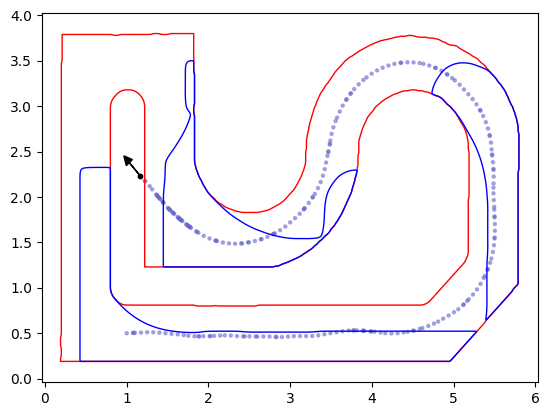

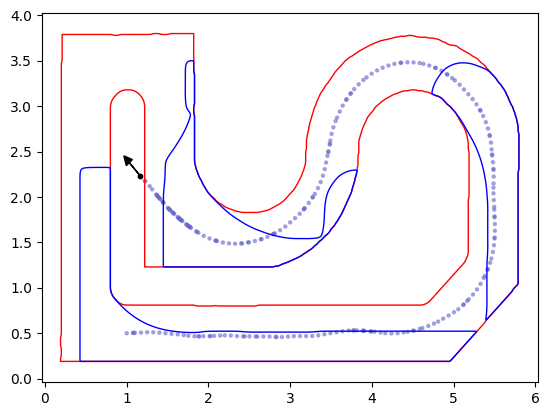

In [16]:
from ipywidgets import interact


# Assuming x_t, matlab_var_dict, data_lx, data, m_t, and list_hallucinations_at_idx are defined elsewhere in your code

def plot_func(idx_to_plot):
    state_plot = x_t[idx_to_plot]
    # Print the state with 2 decimals
    print('[x,y,th]')
    print(np.around(state_plot, decimals=2))
    # Get the index of the closest v and th to the state_first_fltr
    th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - state_plot[2]))

    f1, ax1 = plt.subplots()
    data1 = data_lx
    data1 = data1.transpose()
    CP1 = ax1.contour(matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], data1, 0, colors='red', linewidths=1)

    data2 = data[:, :, th_idx]  # Slice of lx
    data2 = data2.transpose()
    CP2 = ax1.contour(matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], data2, 0, colors='blue', linewidths=1)

    # Plot an arrow with angle theta
    th = matlab_var_dict['th_coord']
    th = th[th_idx]

    SP1 = ax1.scatter(x_t[0:idx_to_plot, 0], x_t[0:idx_to_plot, 1], s=5, c=m_t[0:idx_to_plot], alpha=0.5)
    SP2 = ax1.scatter(x_t[idx_to_plot, 0], x_t[idx_to_plot, 1], s=10, c=[[0.0, 0.0, 0.0]], alpha=1.0)
    # Plot the arrow
    ax1.arrow(x_t[idx_to_plot, 0], x_t[idx_to_plot, 1], np.cos(th) * 0.2, np.sin(th) * 0.2, head_width=0.1, head_length=0.1, fc='k', ec='k')

    # Plot the hallucinations corresponding to idx_to_plot
    for h in list_hallucinations_at_idx[idx_to_plot]:
        # Remove zero rows
        h = h[~np.all(h == 0, axis=1)]
        ax1.plot(h[:, 0], h[:, 1], color='green', alpha=0.2)

    # Set x and y limits
    ax1.set_xlim([0, 6])
    ax1.set_ylim([0, 4])

    # Change aspect ratio to match the grid
    ax1.set_aspect('equal')
    plt.show()

# Use interact to create a slider for idx_to_plot
interact(plot_func, idx_to_plot=(0, len(x_t) - 2, 1))

In [2]:
####backup plot section as ipywidgets breaks sometimes####

idx_to_plot = 0

#def plot_func(idx_to_plot):
    
state_plot = x_t[idx_to_plot]
#print the state with 2 decimals
print('[x,y,th]')
print(np.around(state_plot, decimals=2))
#get the index of the closest v and th to the state_first_fltr
th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - state_plot[2]))

f1, ax1 = plt.subplots()
data1 = data_lx
data1 = data1.transpose()
CP1 = ax1.contour(matlab_var_dict['x_coord'],matlab_var_dict['y_coord'],data1,0)
for c in CP1.collections:
    c.set_edgecolor("red")
    c.set_linewidth(1)
    c.set_label("")

data2 = data[:,:,th_idx] #slice of lx
data2 = data2.transpose()
CP2 = ax1.contour(matlab_var_dict['x_coord'],matlab_var_dict['y_coord'],data2,0)
for c in CP2.collections:
    c.set_edgecolor("blue")
    c.set_linewidth(1)
    c.set_label("")

#plot an arrow with angle theta
th=matlab_var_dict['th_coord']
th = th[th_idx]

SP1 = ax1.scatter(x_t[0:idx_to_plot,0], x_t[0:idx_to_plot,1],s=5,c=m_t[0:idx_to_plot], alpha=0.5)
SP2 = ax1.scatter(x_t[idx_to_plot,0], x_t[idx_to_plot,1],s=10, c=[[0.0,0.0,0.0]], alpha=1.0)
#plot the arrow
ax1.arrow(x_t[idx_to_plot,0], x_t[idx_to_plot,1], np.cos(th)*0.2, np.sin(th)*0.2, head_width=0.1, head_length=0.1, fc='k', ec='k')

#plot the hallucinations corresponding to idx_to_plot
for h in list_hallucinations_at_idx[idx_to_plot]:
    #remove zero rows
    h = h[~np.all(h == 0, axis=1)]
    ax1.plot(h[:,0], h[:,1], color='green', alpha=0.2)

#set x and y limits
ax1.set_xlim([0, 6])
ax1.set_ylim([0, 4])

#change aspect ratio to match the grid
ax1.set_aspect('equal')
plt.show()

#interact(plot_func, idx_to_plot=(0, i, 1))



NameError: name 'x_t' is not defined